<a href="https://colab.research.google.com/github/chaiwencw/miniproject_machinelearning/blob/main/MachineLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem:**
---
1. Monthly Sales Prediction of Each Shop
2. Weekly Demand Prediction for Order

**Make sure these packages are installed!**

In [1]:

#pip install lazypredict

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from lazypredict.Supervised import LazyRegressor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#import dataset
datasetURL = "https://raw.githubusercontent.com/chaiwencw/miniproject_machinelearning/main/shoes_raw_data.csv"
raw_data = pd.read_csv(datasetURL, header = None)
raw_data.columns = ["invoiceNo","date", "country","productID","shop","gender", "sizeUS","sizeEU","sizeUK","originalPrice", 
                    "discount", "year", "month", "sellingPrice"]
raw_data.head(3)


,invoiceNo,date,country,productID,shop,gender,sizeUS,sizeEU,sizeUK,originalPrice,discount,year,month,sellingPrice
0,52389,1/1/2014,United Kingdom,2152,UK2,Male,11.00,44,10.50,159,0.00,2014,1,159.00
1,52390,1/1/2014,United States,2230,US15,Male,11.50,44-45,11.00,199,0.20,2014,1,159.20
2,52391,1/1/2014,Canada,2160,CAN7,Male,9.50,42-43,9.00,149,0.20,2014,1,119.20


**Data Cleanning & Preprocessing**
---
Since it is a raw dataset, we first extract and transform the data that are needed to solve the problem. Then, check and works on the data frame information such as working with NAs, descriptive statistics and etc.

In [4]:
#change date's type from object to datetime
raw_data["date"] = pd.to_datetime(raw_data["date"],format=("%m/%d/%Y"))

In [5]:
#extract and tranform data
dum = raw_data.copy(deep=True)
dum["date"] = pd.to_datetime(raw_data["date"],format=("%m/%d/%Y")).dt.strftime("%m-%Y")
shoesdf = dum.groupby(["date", "country","shop","year","month"]).agg({"productID":"count", "sellingPrice":"sum"}).reset_index().sort_values(by=["date"])
shoesdf =  shoesdf.rename(columns= {"sellingPrice":"revenue", "productID":"sales"})
shoesdf.sample(3)

,date,country,shop,year,month,sales,revenue
63,01-2016,Germany,GER1,2016,1,77,11046.90
14,01-2014,United States,US1,2014,1,7,899.80
722,09-2015,United States,US1,2015,9,7,901.60


In [6]:
# check any null values
shoesdf.isnull().sum()

date       0
country    0
shop       0
year       0
month      0
sales      0
revenue    0
dtype: int64

In [7]:
#check data types
shoesdf.dtypes

date        object
country     object
shop        object
year         int64
month        int64
sales        int64
revenue    float64
dtype: object

In [8]:
shoesdf["date"] = pd.to_datetime(shoesdf["date"],format=("%m-%Y"))

In [9]:
shoesdf = shoesdf.sort_values(by=["date"])
shoesdf.head(3)

,date,country,shop,year,month,sales,revenue
0,2014-01-01,Canada,CAN1,2014,1,2,324.30
7,2014-01-01,Germany,GER2,2014,1,22,3293.90
12,2014-01-01,United Kingdom,UK4,2014,1,7,1177.40


In [10]:
shoesdf.tail(3)

,date,country,shop,year,month,sales,revenue
1006,2016-12-01,United Kingdom,UK5,2016,12,9,1447.80
1000,2016-12-01,Germany,GER2,2016,12,62,8689.00
1021,2016-12-01,United States,US9,2016,12,10,1506.90


In [11]:
#view dataframe shape
shoesdf.shape

(1022, 7)

*shoesdf* consists of 10141 rows and 7 columns.

In [12]:
#descriptive statistics
shoesdf.describe()

,year,month,sales,revenue
count,1022.00,1022.00,1022.00,1022.00
mean,2015.02,6.50,14.64,2108.68
std,0.81,3.46,16.34,2346.69
min,2014.00,1.00,1.00,79.50
25%,2014.00,4.00,5.00,723.50
50%,2015.00,6.50,9.00,1302.45
75%,2016.00,9.75,17.00,2425.45
max,2016.00,12.00,108.00,15298.40


From the table above, the mean and the standard deviation of monthly *sales* are 1 unit and 1 unit, respectively while the mean of daily *revenue* is 148.62 and its standard deviation is 44.81.

For problem 2, 'weekly sales prediction based on the last seven days sales'.

In [13]:
#extract and transform dataset
salesdf = raw_data.resample('W-Sun', label='right', closed = 'right', on='date').productID.count().reset_index(name="sales").sort_values(by="date")
salesdf = salesdf.rename(columns={"date":"week"})
salesdf.head()

,week,sales
0,2014-01-05,38
1,2014-01-12,42
2,2014-01-19,57
3,2014-01-26,56
4,2014-02-02,45


In [14]:
salesdf["last_7_days_sales"] = salesdf.apply(lambda x : salesdf[(salesdf['week'] < x.week) & (salesdf['week'] >= (x.week - timedelta(days=7)))]
                                             ["sales"].sum(), axis=1)
salesdf.head(3)

,week,sales,last_7_days_sales
0,2014-01-05,38,0
1,2014-01-12,42,38
2,2014-01-19,57,42


In [15]:
salesdf.tail(3)

,week,sales,last_7_days_sales
154,2016-12-18,111,122
155,2016-12-25,88,111
156,2017-01-01,85,88


Note that the first row's *last_7_days_sales value* is 0. Also, the last row's *date* is 2017-01-01, which is not included in the raw dataset. SO, we drop the first and last row of *salesdf*

In [16]:
salesdf = salesdf.head(-1).tail(-1)

In [17]:
salesdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 1 to 155
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   week               155 non-null    datetime64[ns]
 1   sales              155 non-null    int64         
 2   last_7_days_sales  155 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 KB


In [18]:
#descriptive statistics
salesdf.describe()

,sales,last_7_days_sales
count,155.00,155.00
mean,95.77,95.45
std,40.67,40.93
min,31.00,31.00
25%,58.00,57.00
50%,92.00,92.00
75%,127.00,127.00
max,186.00,186.00


From the table above, the mean and the standard deviation of weekly *sales *is about 98 and 195, respectively.

**Exploratory Data Analysis**
---
For problem 1, we perform analysis on the historical shops' shoes sales dataset.(*shoesdf*). This dataset describe the sales of each shop in different countries. 

For problem 2, we perform analysis on the weekly sales dataset(*sales_df*. This dataset descibe the weekly sales over years.

**Data Visualization**
---
Plots for

**Problem 1**
*   total sales of every shop in each country.
*   the typical time series for sales (number of product sold) in each country
*   monthly sales in each year
*   time series plot of each shop

**Problem 2**
*   weekly time series plot




**Overall Sales of Each Shop in Different Countries**

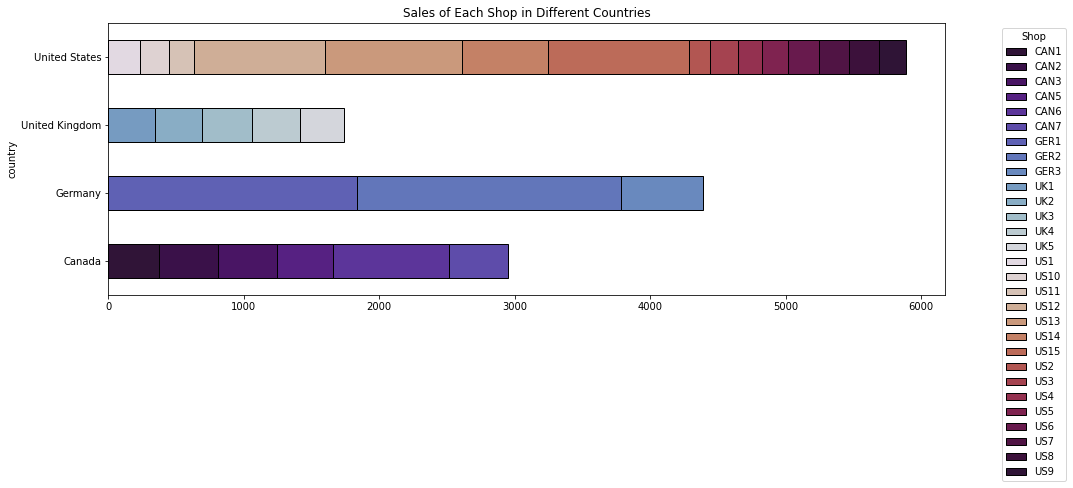

In [19]:

df = shoesdf.groupby(["date","country","shop"]).sales.sum().reset_index(name="sales").sort_values(by=["date"])
pivoted_table = pd.pivot_table(data=df, index="country", values="sales", columns="shop", aggfunc = np.sum)
pivoted_table.plot(kind = "barh",stacked =True, figsize=(15,5), title="Sales of Each Shop in Different Countries", 
                   colormap = "twilight_shifted", edgecolor="black").legend(title="Shop", loc="best",bbox_to_anchor=(1.15,1))
plt.show()

The stacked horizontal bar chart above shows the total sales of every shop in each country. Each country has a different number of shops. United State has the highest number of shops, but not every shop achieved high sales. Then, follows by Canada and United Kingdom. Germany has the least number of shops. Although there are only three shops in Germany, the total achieved sales over three years are higher than the United Kingdom and Canada.

**Monthly Sales of Each Shop in Different Countries**

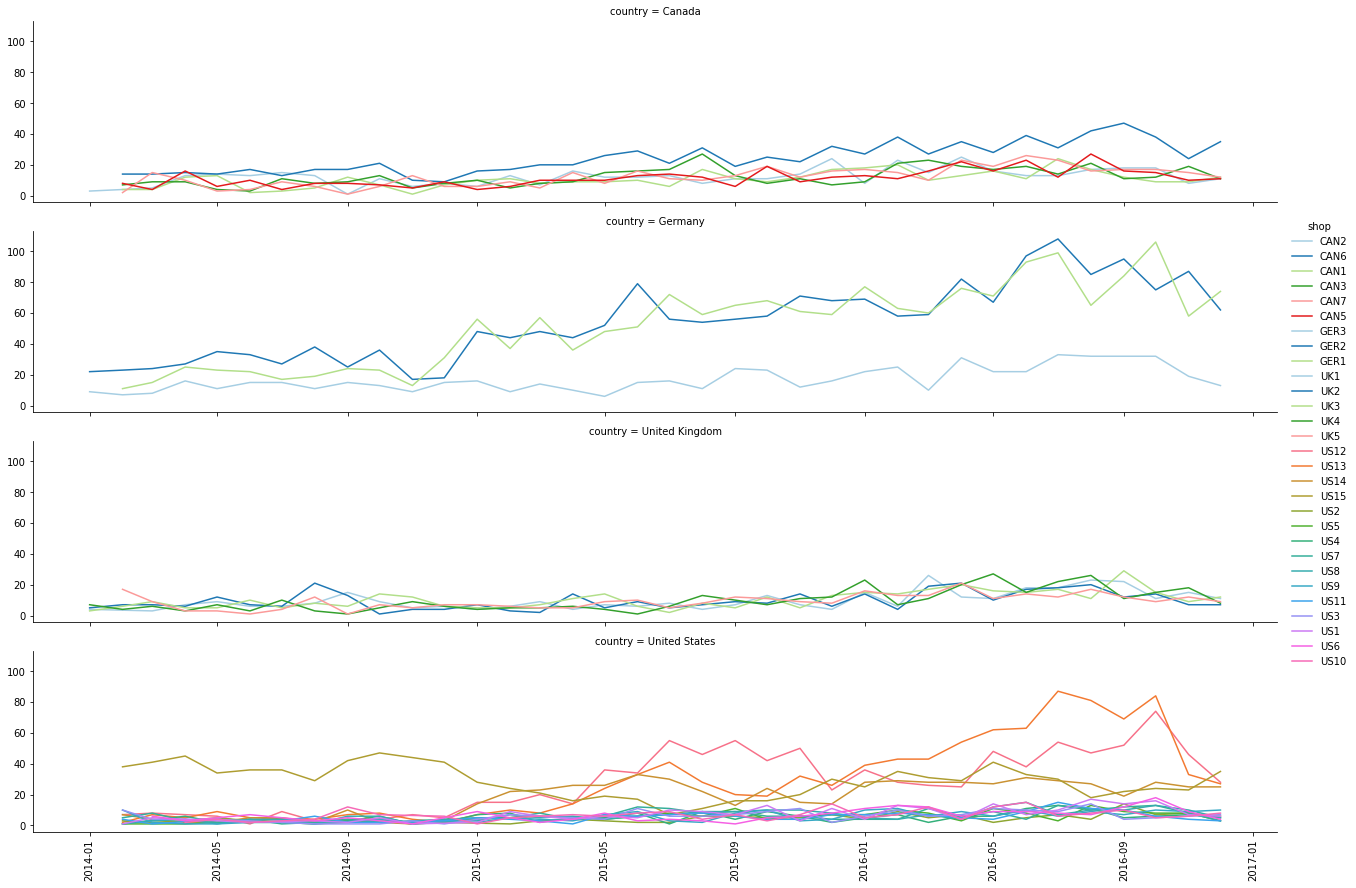

In [20]:
sns.set_palette(sns.color_palette("Paired"))
g = sns.FacetGrid(data=df.tail(1000), col="country",col_wrap=1, height=3, aspect=6)
g.map_dataframe(sns.lineplot, x = "date",y ="sales",hue="shop" ).add_legend(title="shop")
plt.tick_params(axis='x', rotation=90)

The time series plot above is the daily sales (number of product sold) of each shop in each country (for last 1000 points of values). It clearly shows that the shops in United Kingdom and Canada archieved low sales compared to the other two countries.

**Monthly Sales of Each Year**

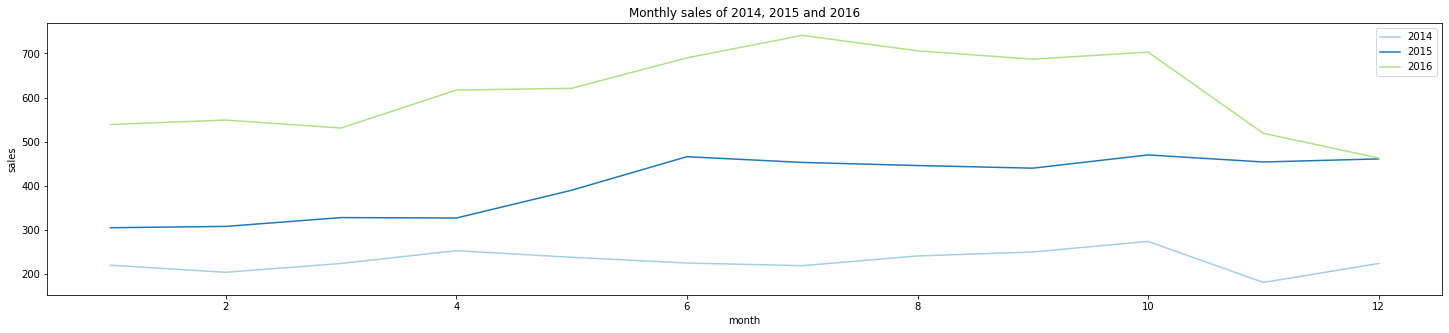

In [21]:
# Line chart of sales by year and month
df1 = shoesdf.groupby(["year","month"]).sales.sum().reset_index()
fig, ax = plt.subplots(figsize=(25,5))

for name, group in df1.groupby('year'):
    ax.plot(group['month'], group['sales'], label=name)

plt.title('Monthly sales of 2014, 2015 and 2016')  
plt.xlabel('month')
plt.ylabel('sales')
ax.legend()
plt.show()

**Time Series Plot for Each Shop**

In [22]:
#time-series plot function: plot historical actual data and trend 
def tsplot(tsdf, title):
    
    t = tsdf.date
    y = tsdf['sales']
    yd = signal.detrend(y)
    plt.figure(figsize=(15,3))
    plt.plot(t, y, label="Actual Data")
    plt.plot(t, y-yd, "--r", label="Trend")
    plt.legend(loc=0)
    plt.title(title)
    plt.show()
    return


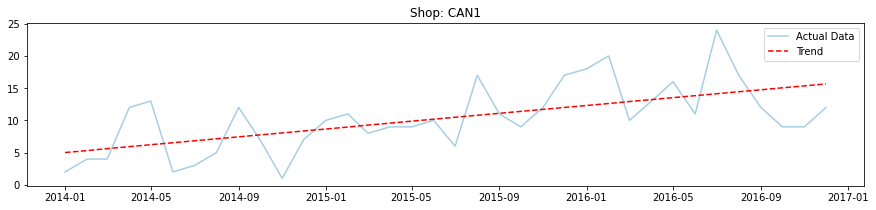

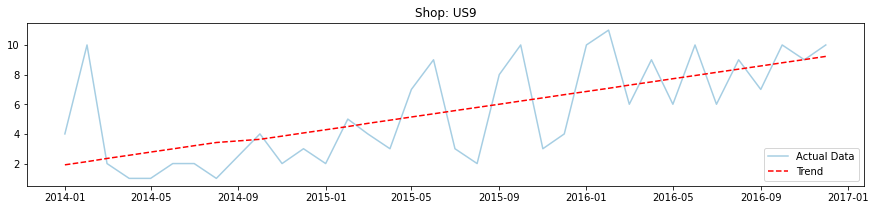

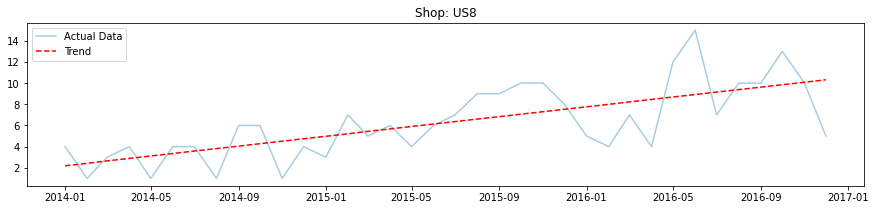

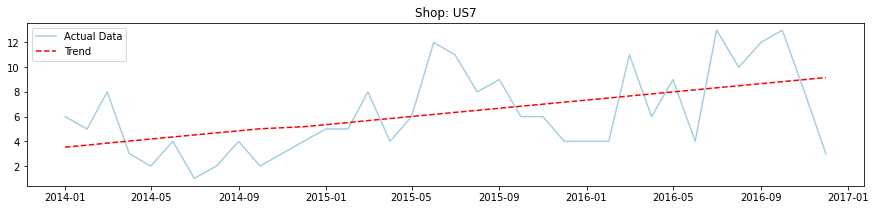

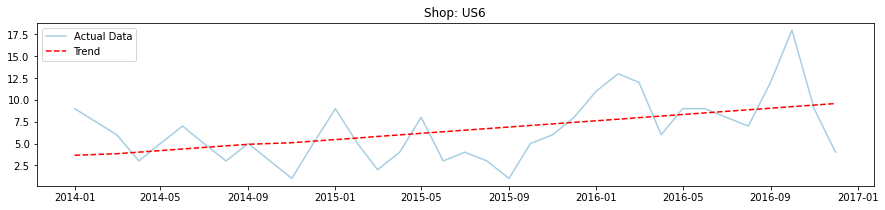

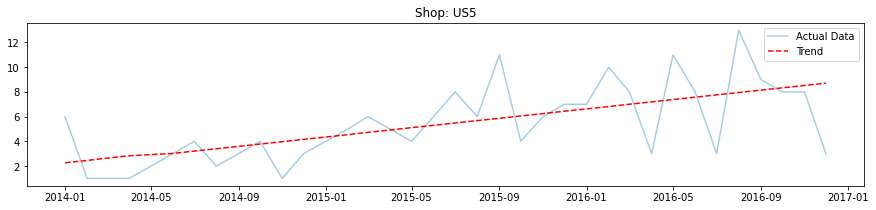

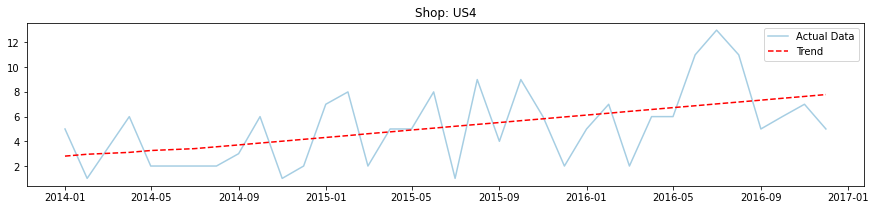

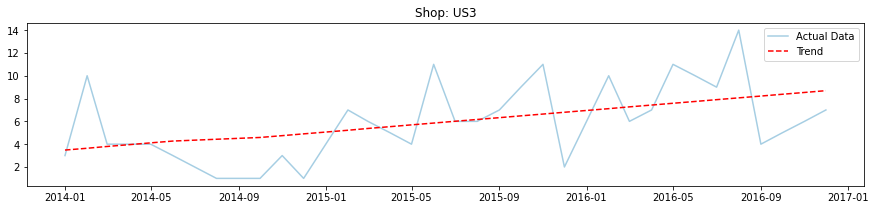

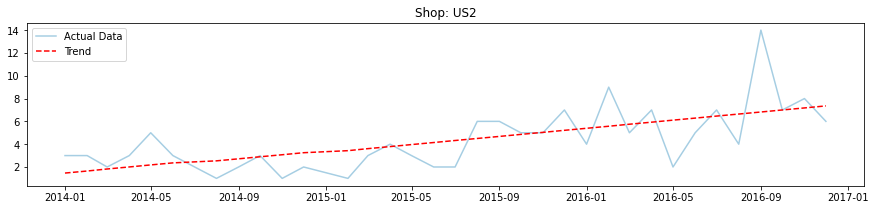

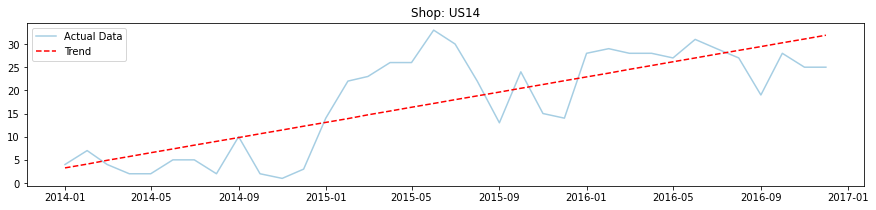

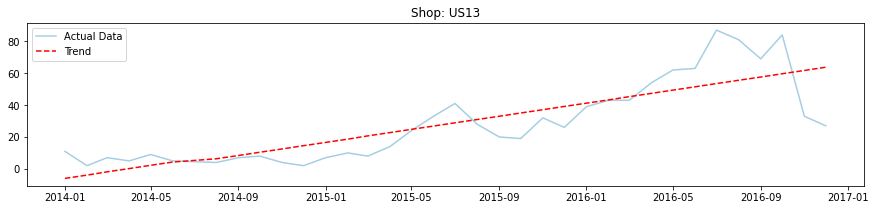

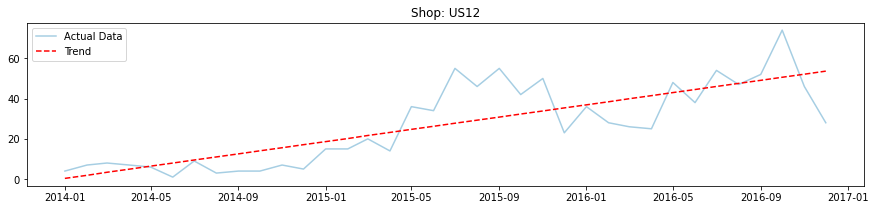

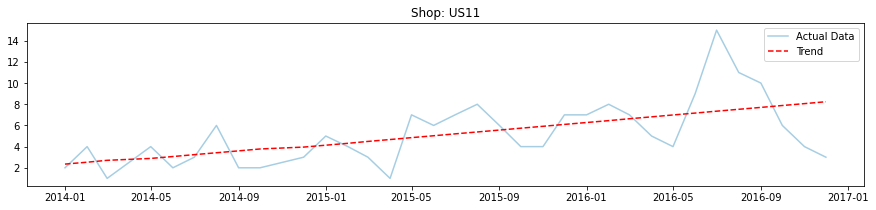

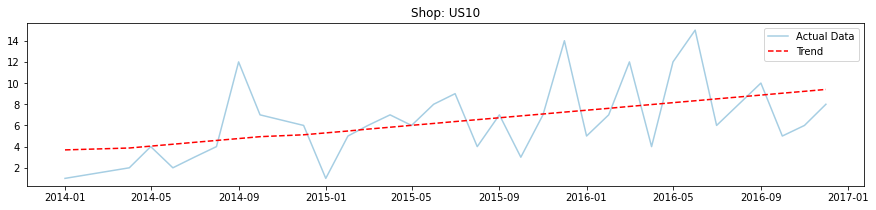

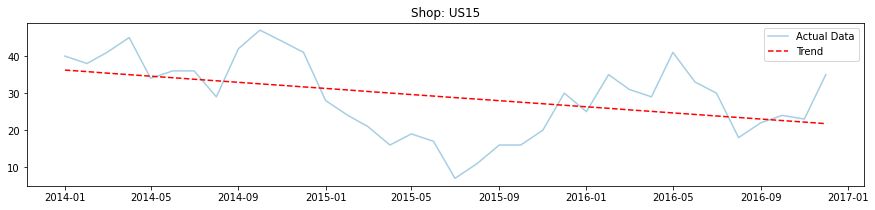

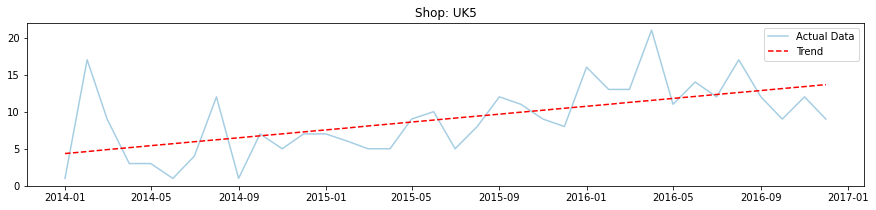

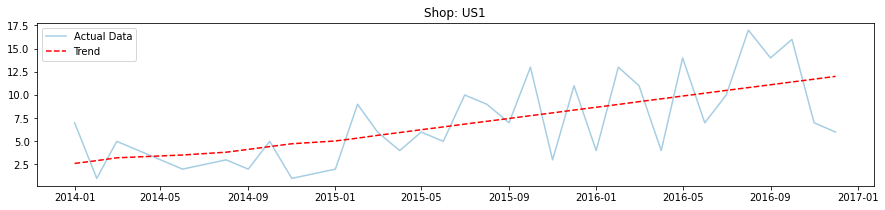

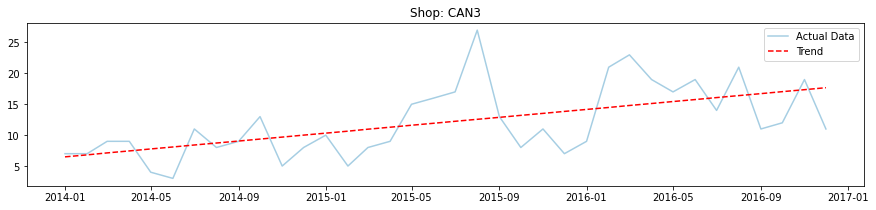

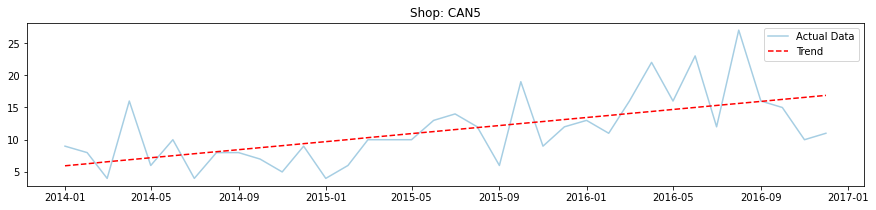

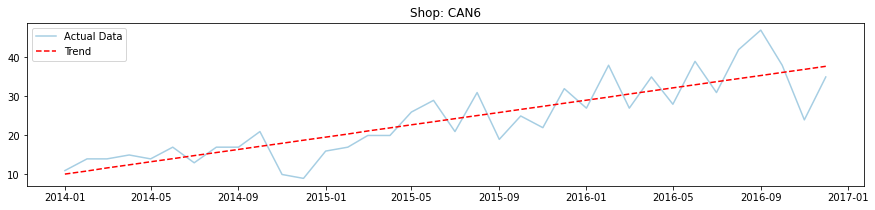

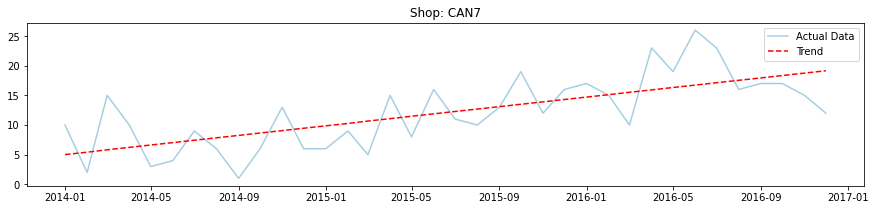

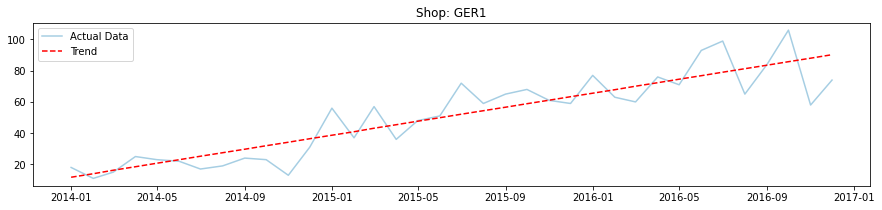

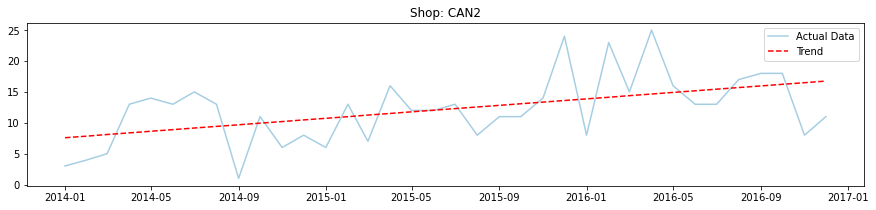

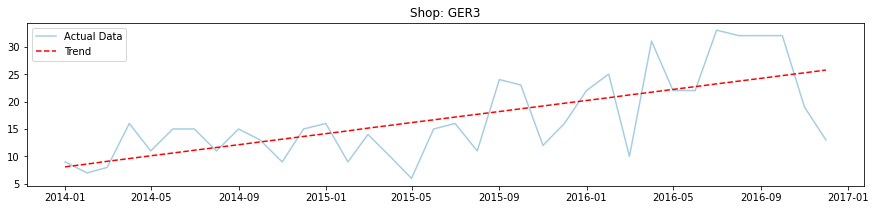

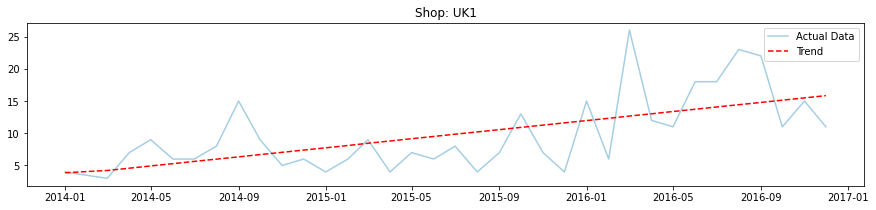

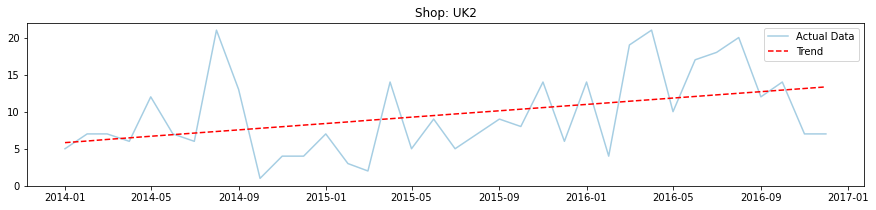

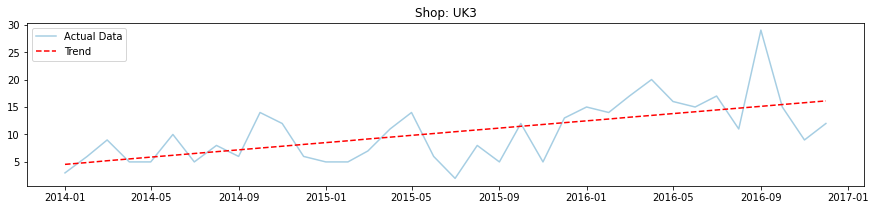

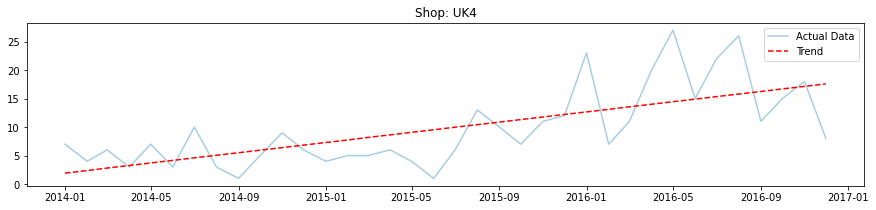

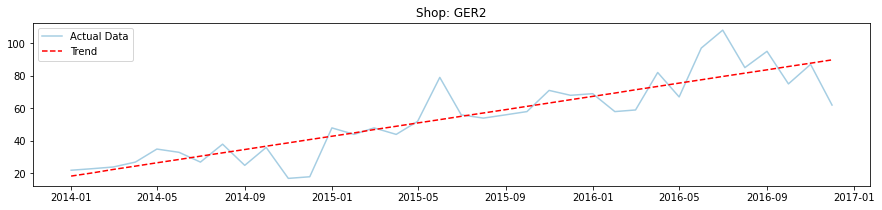

In [23]:
for s in df['shop'].unique():
    tmdf = df[df['shop']==s]
    tsplot(tmdf, "Shop: {}".format(s))

From the time series plot of each shop, we can see that the shops' monthly sales are increasing.

**Weekly Time Series Plot**

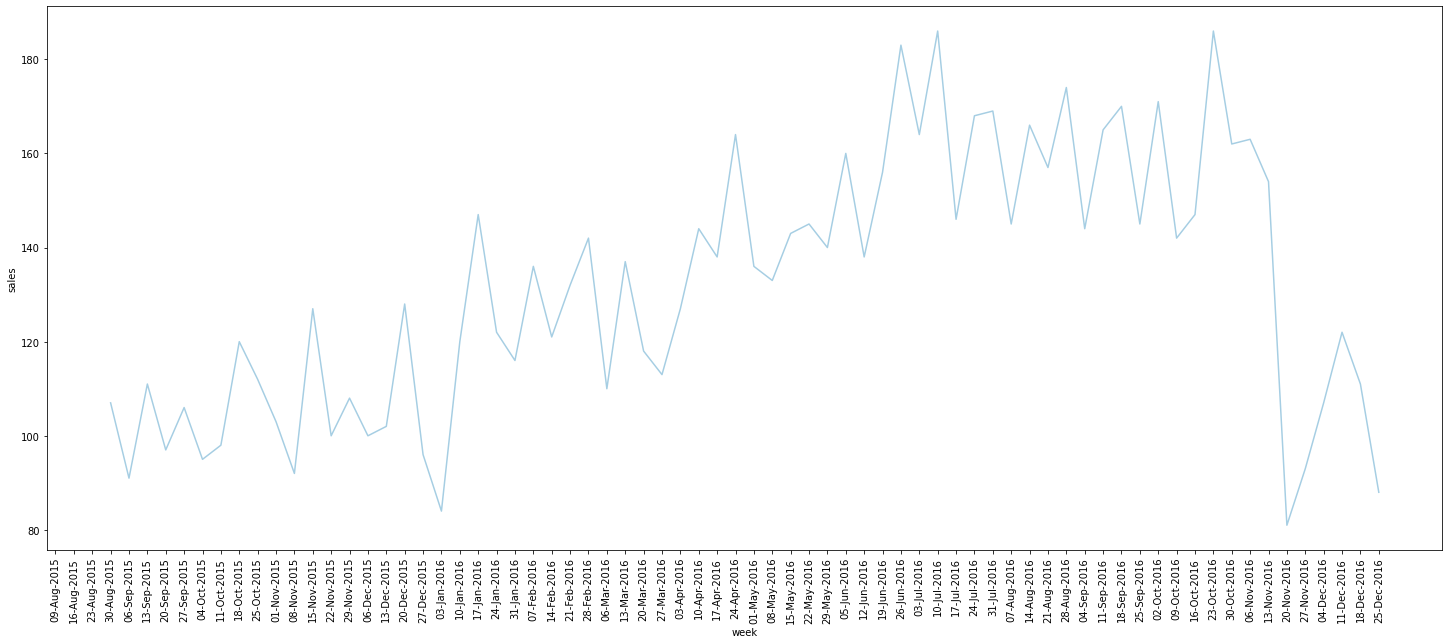

In [24]:
weekly_date = salesdf.week.dt.strftime("%d-%b-%Y")
plt.figure(figsize=(25,10))
g = sns.lineplot(data=salesdf.tail(70), x=weekly_date, y="sales")
g.tick_params(axis='x', rotation=90)

**Machine Learning**
---



**For Problem 1,**

First, we convert a categorical variable into numeric.

In [25]:
shoesdf = shoesdf.drop("country",axis=1)
# map shop ID into numeric values
shop = shoesdf.shop.unique()
shop_dict = dict(zip(shop,range(len(shop))))
shoesdf['shop'] = shoesdf["shop"].map(shop_dict)
shoesdf

,date,shop,year,month,sales,revenue
0,2014-01-01,0,2014,1,2,324.30
7,2014-01-01,1,2014,1,22,3293.90
12,2014-01-01,2,2014,1,7,1177.40
10,2014-01-01,3,2014,1,5,773.20
9,2014-01-01,4,2014,1,4,499.70
...,...,...,...,...,...,...
1010,2016-12-01,26,2016,12,28,4086.90
1009,2016-12-01,27,2016,12,3,451.20
1006,2016-12-01,13,2016,12,9,1447.80
1000,2016-12-01,1,2016,12,62,8689.00


Then, split the dataset into train and test set.

In [26]:
test_df1 =shoesdf[shoesdf['date'] >="2016-01"]
train_df1=shoesdf[shoesdf['date'] <"2016-01"]
feature = ["shop","revenue"]
label = "sales"
X_train, y_train = train_df1[feature], train_df1[label]
X_test, y_test = test_df1[feature], test_df1[label]
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((674, 2), (348, 2), (674,), (348,))

Next, perform machine learning algorithm for predictions.

In [27]:
xgbreg = XGBRegressor(n_estimators=500, learning_rate=0.01)
xgbreg.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],eval_metric='mae')

[0]	validation_0-mae:10.67205	validation_1-mae:20.48312
[1]	validation_0-mae:10.56770	validation_1-mae:20.30141
[2]	validation_0-mae:10.46445	validation_1-mae:20.11998
[3]	validation_0-mae:10.36223	validation_1-mae:19.94229
[4]	validation_0-mae:10.26097	validation_1-mae:19.76430
[5]	validation_0-mae:10.16081	validation_1-mae:19.59072
[6]	validation_0-mae:10.06161	validation_1-mae:19.41818
[7]	validation_0-mae:9.96344	validation_1-mae:19.24746
[8]	validation_0-mae:9.86616	validation_1-mae:19.07836
[9]	validation_0-mae:9.76987	validation_1-mae:18.91133
[10]	validation_0-mae:9.67449	validation_1-mae:18.74542
[11]	validation_0-mae:9.58019	validation_1-mae:18.58399
[12]	validation_0-mae:9.48664	validation_1-mae:18.42129
[13]	validation_0-mae:9.39415	validation_1-mae:18.26268
[14]	validation_0-mae:9.30258	validation_1-mae:18.10582
[15]	validation_0-mae:9.21194	validation_1-mae:17.95004
[16]	validation_0-mae:9.12203	validation_1-mae:17.79168
[17]	validation_0-mae:9.03312	validation_1-mae:17.6

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
predictions = xgbreg.predict(X_test)

In [29]:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("Mean Squared Error:", mse)
print("R Squared Score:", r2)

Mean Squared Error: 16.92694863486798
R Squared Score: 0.9597913670849392


In [30]:
test_df1 = test_df1.reset_index().drop('index', axis=1)
test_df1['predictions'] = pd.Series(predictions)
test_df1

,date,shop,year,month,sales,revenue,predictions
0,2016-01-01,10,2016,1,13,2121.00,14.22
1,2016-01-01,9,2016,1,27,4297.80,29.06
2,2016-01-01,7,2016,1,77,11046.90,73.71
3,2016-01-01,0,2016,1,18,2159.10,14.80
4,2016-01-01,5,2016,1,22,3289.20,22.85
...,...,...,...,...,...,...,...
343,2016-12-01,26,2016,12,28,4086.90,25.23
344,2016-12-01,27,2016,12,3,451.20,3.09
345,2016-12-01,13,2016,12,9,1447.80,10.10
346,2016-12-01,1,2016,12,62,8689.00,64.44


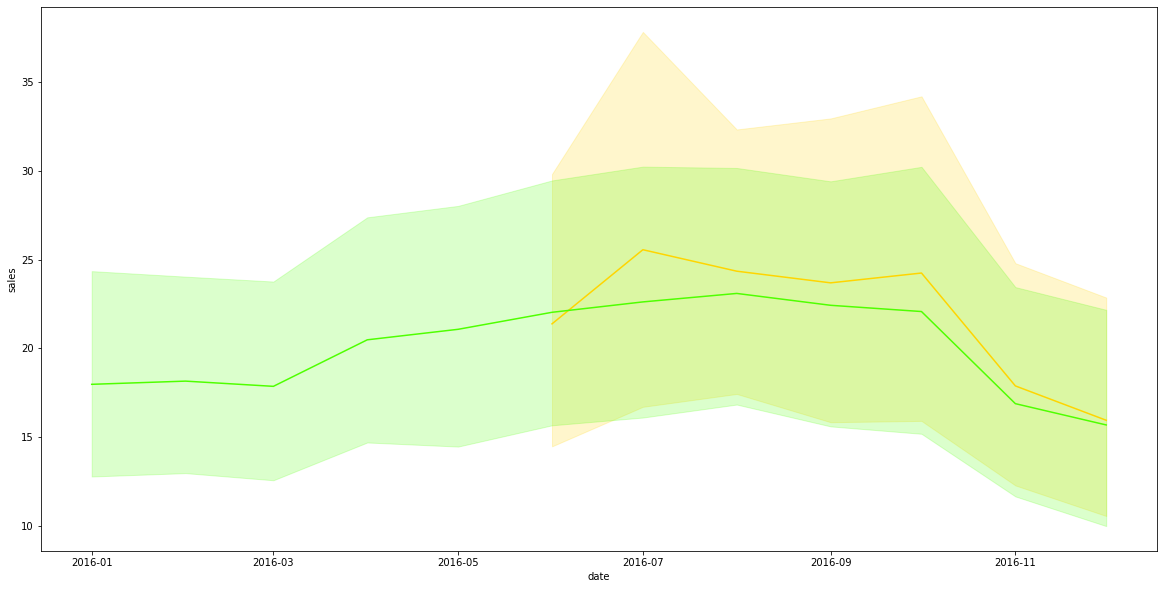

In [31]:
sns.set_palette(palette="hsv")
plt.figure(figsize=(20,10))
sns.lineplot(data = shoesdf.tail(200), x = "date", y = "sales")
sns.lineplot(data = test_df1, x = "date", y = "predictions")

In [32]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(r2_score(y_pred, y_test))

-0.49406881963052807


In [33]:
#lazy predict - show all machine learning regressors' prediction score
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models,pred = reg.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████| 42/42 [00:02<00:00, 15.82it/s]


                               Adjusted R-Squared  ...  Time Taken
Model                                              ...            
OrthogonalMatchingPursuit                    0.99  ...        0.03
OrthogonalMatchingPursuitCV                  0.99  ...        0.02
LinearRegression                             0.99  ...        0.02
LassoLarsCV                                  0.99  ...        0.02
TransformedTargetRegressor                   0.99  ...        0.01
LarsCV                                       0.99  ...        0.04
Lars                                         0.99  ...        0.03
BayesianRidge                                0.99  ...        0.02
RidgeCV                                      0.99  ...        0.01
LassoCV                                      0.99  ...        0.07
SGDRegressor                                 0.99  ...        0.01
Ridge                                        0.99  ...        0.01
HuberRegressor                               0.99  ...        

**For Problem 2,**

Similar steps in Problem 1

In [34]:
test_df2 =salesdf[salesdf['week'] >="2016-05-01"]
train_df2=salesdf[salesdf['week'] <"2016-05-01"]

In [35]:
# fig, ax = plt.subplots(figsize=(20,5))
# sns.lineplot(data = salesdf.tail(50), x=weekly_date,y="sales")
# sns.lineplot(data= salesdf.tail(50), x=weekly_date, y="last_7_days_sales")
# plt.grid(linestyle='-', linewidth=0.3)
# ax.tick_params(axis='x', rotation=90)

In [36]:
feature2 = ["last_7_days_sales"]
label2 = "sales"
X_train2, y_train2 = train_df2[feature2], train_df2[label2]
X_test2, y_test2 = test_df2[feature2], test_df2[label2]

In [37]:
X_train2.shape,X_test2.shape, y_train2.shape, y_test2.shape

((120, 1), (35, 1), (120,), (35,))

In [38]:
reg2 = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg2.fit(X_train2, 
        y_train2,
        eval_set=[(X_train2, y_train2), (X_test2, y_test2)],
        eval_metric='mae')

[0]	validation_0-mae:79.41162	validation_1-mae:145.87378
[1]	validation_0-mae:78.63097	validation_1-mae:144.82933
[2]	validation_0-mae:77.85803	validation_1-mae:143.79515
[3]	validation_0-mae:77.09276	validation_1-mae:142.77109
[4]	validation_0-mae:76.33491	validation_1-mae:141.75708
[5]	validation_0-mae:75.58450	validation_1-mae:140.75307
[6]	validation_0-mae:74.84595	validation_1-mae:139.75705
[7]	validation_0-mae:74.11465	validation_1-mae:138.77074
[8]	validation_0-mae:73.39045	validation_1-mae:137.79414
[9]	validation_0-mae:72.67336	validation_1-mae:136.82715
[10]	validation_0-mae:71.96326	validation_1-mae:135.86961
[11]	validation_0-mae:71.26006	validation_1-mae:134.92149
[12]	validation_0-mae:70.56383	validation_1-mae:133.98268
[13]	validation_0-mae:69.87434	validation_1-mae:133.05306
[14]	validation_0-mae:69.18869	validation_1-mae:132.13420
[15]	validation_0-mae:68.51261	validation_1-mae:131.22273
[16]	validation_0-mae:67.84317	validation_1-mae:130.32019
[17]	validation_0-mae:67

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
predictions2 = reg2.predict(X_test2)

In [45]:
mse = mean_squared_error(y_test2, predictions2)
r2 = r2_score(y_test2, predictions2)
print("Mean Squared Error:", mse)
print("R Squared Score:", r2)

Mean Squared Error: 1300.675021953257
R Squared Score: -0.9185152340671163


In [46]:
test_df2 = test_df2.reset_index().drop('index', axis=1)
test_df2['predictions'] = pd.Series(predictions2)
test_df2

,week,sales,last_7_days_sales,predictions
0,2016-05-01,136,164,120.12
1,2016-05-08,133,136,119.14
2,2016-05-15,143,133,134.09
3,2016-05-22,145,143,130.91
4,2016-05-29,140,145,130.91
5,2016-06-05,160,140,110.90
6,2016-06-12,138,160,120.12
7,2016-06-19,156,138,149.71
8,2016-06-26,183,156,120.12
9,2016-07-03,164,183,120.12


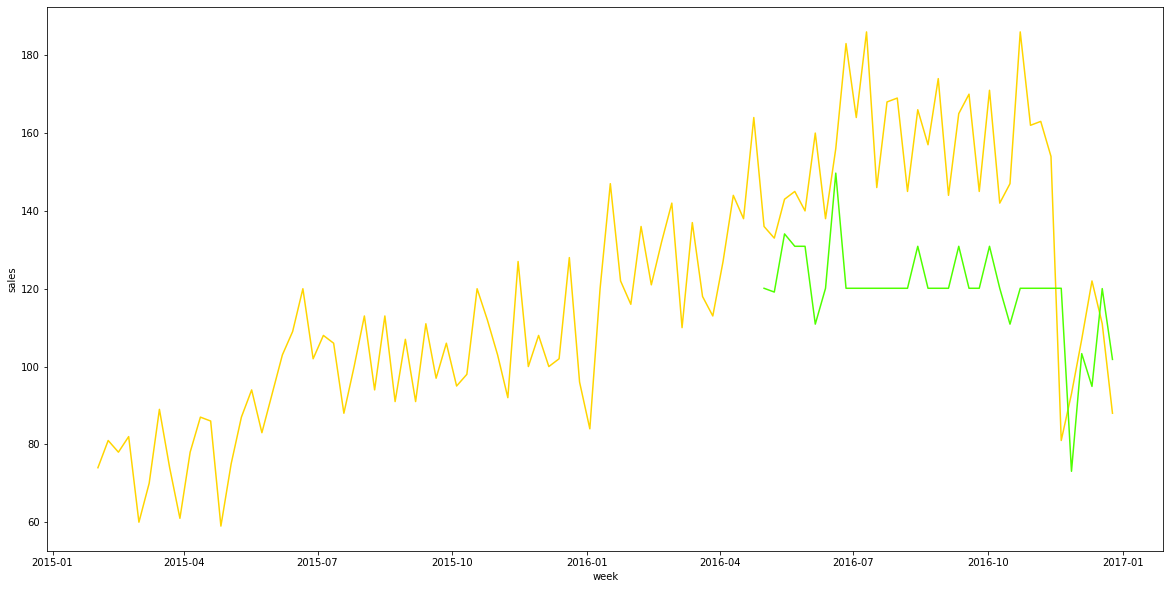

In [50]:
plt.figure(figsize=(20,10))
sns.lineplot(data = salesdf.tail(100), x = "week", y = "sales",)
sns.lineplot(data = test_df2, x = "week", y = "predictions")

In [48]:
lzreg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models,pred = lzreg.fit(X_train2, X_test2, y_train2, y_test2)
print(models)

 76%|███████▌  | 32/42 [00:01<00:00, 28.72it/s]

OrthogonalMatchingPursuitCV model failed to execute
Found array with 1 feature(s) (shape=(120, 1)) while a minimum of 2 is required by OrthogonalMatchingPursuitCV.


100%|██████████| 42/42 [00:01<00:00, 30.95it/s]

                               Adjusted R-Squared  ...  Time Taken
Model                                              ...            
LarsCV                                       0.20  ...        0.02
OrthogonalMatchingPursuit                    0.20  ...        0.02
Lars                                         0.20  ...        0.01
LassoLarsCV                                  0.20  ...        0.02
LassoLarsIC                                  0.20  ...        0.01
TransformedTargetRegressor                   0.20  ...        0.01
LinearRegression                             0.20  ...        0.01
LassoCV                                      0.20  ...        0.07
SGDRegressor                                 0.20  ...        0.01
BayesianRidge                                0.20  ...        0.01
Ridge                                        0.20  ...        0.01
RidgeCV                                      0.20  ...        0.01
ElasticNetCV                                 0.19  ...        